In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import pandas as pd

In [2]:
# %%writefile haze.py
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2

def set_visibility(depth_map, visibility):
    assert(0 <= visibility <= 1)
    d = depth_map
    d = d / d.max()
    d = d + ((d.max() - d.min()) / visibility - (d.max() + d.min())) / 2
    d = d / d.max()
    return np.clip(d, 0, 1)

def make_hazed(img_ideal, atmospheric_light, beta, depth_map):
    assert(img_ideal.dtype == np.uint8)
    J = img_ideal.astype(np.float32) / 255.0
    d = depth_map
    t = np.exp(-beta * d)
    I = J * t[..., None] + atmospheric_light * (1 - t[..., None])
    return (I * 255).clip(0, 255).astype(np.uint8)

def prepare_mask(mask, size, sigma=0.05):
    return gaussian_filter(cv2.resize(mask, size), sigma=sigma*size[0])

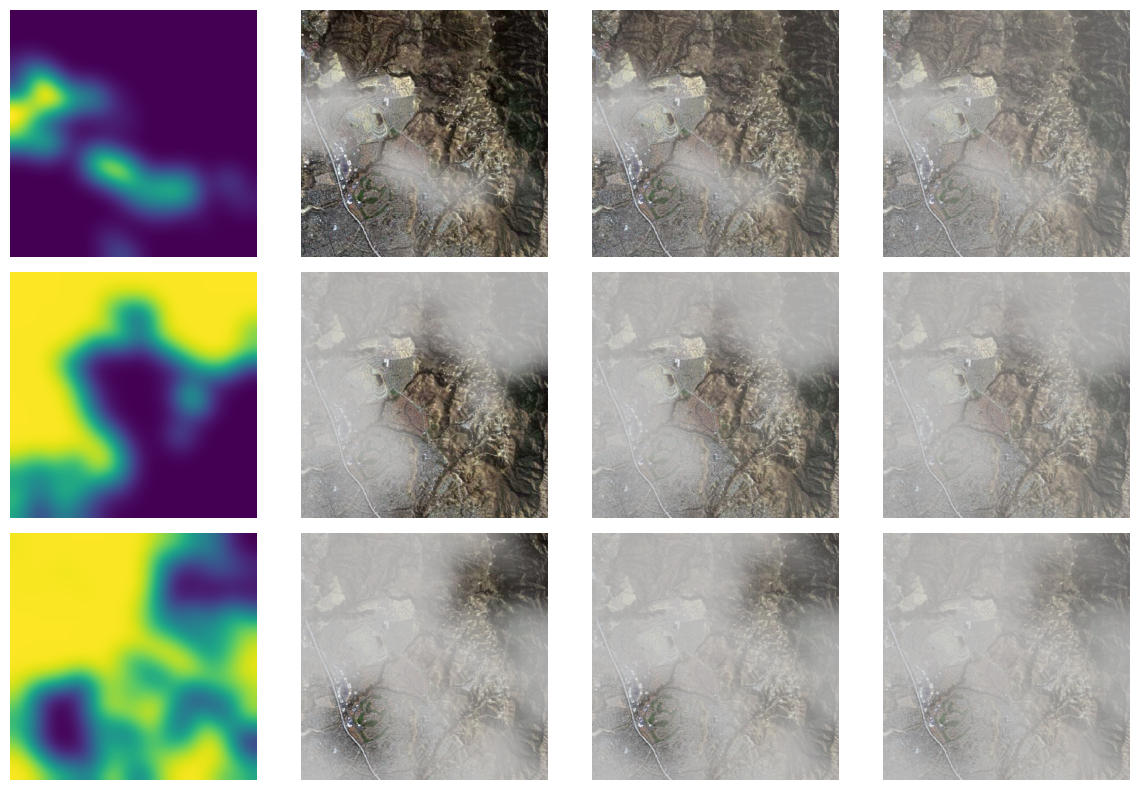

In [3]:
img_source = cv2.cvtColor(cv2.imread('img/source.png'), cv2.COLOR_BGR2RGB)

mask1 = prepare_mask(cv2.imread('img/mask1.png', cv2.IMREAD_GRAYSCALE), (512, 512))
mask2 = prepare_mask(cv2.imread('img/mask2.png', cv2.IMREAD_GRAYSCALE), (512, 512))
mask3 = prepare_mask(cv2.imread('img/mask3.png', cv2.IMREAD_GRAYSCALE), (512, 512))
masks = [
    set_visibility(mask1, 1), set_visibility(mask1, 0.75), set_visibility(mask1, 0.5),
    set_visibility(mask2, 1), set_visibility(mask2, 0.75), set_visibility(mask2, 0.5),
    set_visibility(mask3, 1), set_visibility(mask3, 0.75), set_visibility(mask3, 0.5)
]

images = [make_hazed(img_source, np.array([0.8, 0.8, 0.8]), 1.8, i) for i in masks]
images[6:6] = [mask3]
images[3:3] = [mask2]
images[0:0] = [mask1]

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.ravel() if isinstance(axes, np.ndarray) else [axes]

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

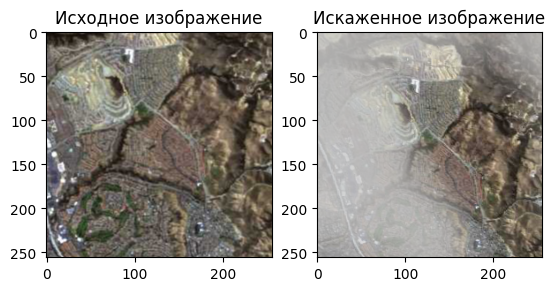

In [4]:
w, h = 256, 256
cx, cy = 210, 290

img_ideal = cv2.getRectSubPix(img_source, (w, h), (cx, cy))
plt.subplot(121), plt.imshow(img_ideal), plt.title('Исходное изображение')

matrix_distortion = np.array([
    [ 0.9,  0.05, w / 10],
    [0.1,  0.96, h / 10],
    [ 0.0000,  0.0003,  1]
], dtype=np.float32)  # TODO
sx = cx - w // 2
sy = cy - h // 2
matrix_shift = np.array([
    [ 1,  0,  -sx],
    [ 0,  1,  -sy],
    [ 0,  0,  1]
], dtype=np.float32)
matrix_distortion_and_shift = matrix_distortion @ matrix_shift
img_input = cv2.warpPerspective(images[5], matrix_distortion_and_shift, (w, h))
plt.subplot(122), plt.imshow(img_input), plt.title('Искаженное изображение')

plt.show()

In [5]:
# %%writefile feature_matcher.py
import cv2
import numpy as np
from abc import ABC, abstractmethod
from typing import Dict, Any

class FeatureMatcher(ABC):
    def __init__(self, **params):
        self.params = params
        self._init_matcher()
    
    def __str__(self):
        return self.__class__.__name__.replace('FeatureMatcher', '')

    @abstractmethod
    def _init_matcher(self):
        """Инициализация детектора и дескриптора особенностей"""
        pass
        
    def estimate_transform(self, kp1: np.ndarray, kp2: np.ndarray, matches: Any) -> np.ndarray:
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
        
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
        return M
    
    def process_images(self, img_ideal: np.ndarray, img_input: np.ndarray) -> Dict[str, Any]:
        kp1, desc1 = self.detect_and_compute(img_ideal)
        kp2, desc2 = self.detect_and_compute(img_input)
        
        matches = self.match_features(desc1, desc2)
        matches = sorted(matches, key = lambda x:x.distance)
        
        M = self.estimate_transform(kp1, kp2, matches)
        
        return {
            'keypoints1': kp1,
            'keypoints2': kp2,
            'matches': matches,
            'matrix_alg': M
        }
    
    def detect_and_compute(self, image):
        return self.detector.detectAndCompute(image, None)
    
    def match_features(self, desc1, desc2):
        return self.matcher.match(desc1, desc2)

class SIFTFeatureMatcher(FeatureMatcher):
    def _init_matcher(self):
        self.detector = cv2.SIFT_create()
        self.matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
class FASTBRIEFFeatureMatcher(FeatureMatcher):
    def __str__(self):
        return 'FAST+BRIEF'
          
    def _init_matcher(self):
        self.detector = cv2.FastFeatureDetector_create()
        self.descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    def detect_and_compute(self, image):
        kp = self.detector.detect(image, None)
        kp, desc = self.descriptor.compute(image, kp)
        return kp, desc
    
    def match_features(self, desc1, desc2):
        return self.matcher.match(desc1, desc2)

class ORBFeatureMatcher(FeatureMatcher):
    def _init_matcher(self):
        self.detector = cv2.ORB_create()
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

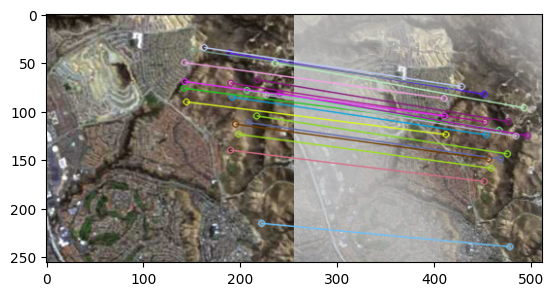

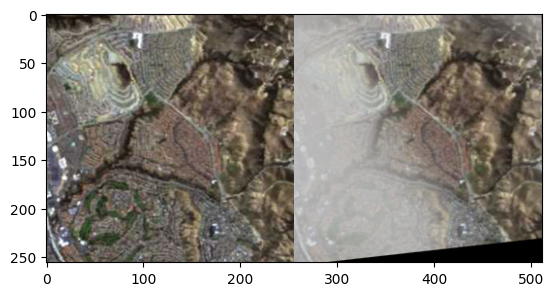

In [6]:
matcher = SIFTFeatureMatcher()
# matcher = FASTBRIEFFeatureMatcher()
# matcher = ORBFeatureMatcher()

results = matcher.process_images(img_ideal, img_input)

matched_vis = cv2.drawMatches(
    img_ideal, results['keypoints1'],
    img_input, results['keypoints2'],
    results['matches'][:20], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.imshow(matched_vis)
plt.show()

matrix_alg = results['matrix_alg']
img_alg = cv2.warpPerspective(img_input, matrix_alg, (w, h))
aligned_vis = np.hstack((img_ideal, img_alg))
plt.imshow(aligned_vis)
plt.show()

In [7]:
# %%writefile loss.py
import numpy as np
import cv2

def make_perspective_transform(m):

    def transform(x):
        points = np.array(x, dtype=np.float32)
        return cv2.perspectiveTransform(points.reshape(-1, 1, 2), m).reshape(-1, 2)
    
    return transform

def make_loss(p):

    def loss(vestigial, region):
        d = lambda x: np.linalg.norm(vestigial(x) - x, axis=1)
        if p == np.inf:
            return d(region).max()
        return ((d(region) ** p).sum() / len(region)) ** (1/p)
    
    return loss

loss_2 = make_loss(2)
loss_inf = make_loss(np.inf)

In [8]:
for matcher in SIFTFeatureMatcher(), FASTBRIEFFeatureMatcher(), ORBFeatureMatcher():
    matrix_alg = matcher.process_images(img_ideal, img_input)['matrix_alg']
    transform_vestigial = make_perspective_transform(matrix_alg @ matrix_distortion)
    region = np.array(list(np.ndindex(w, h)))  # TODO
    print(loss_2(transform_vestigial, region))

0.815249680041921
1.2512006088839334
0.8338335805195766
